In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import time
import random

import matplotlib.pyplot as plt

In [64]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

In [12]:
th = 2.33
rho = 0.52 # Not given in the papers
N_samples = 1000000
n = 100

eps = np.random.normal(0, 1, (N_samples, n))
Z = np.random.normal(0, 1, N_samples)

In [13]:
ci = 1
tail_th = 5

In [14]:
X_i = rho * Z[:, np.newaxis] + np.sqrt(1 - rho**2) * eps

def V(xi): # Xi comes from Z and eps
    defaults = xi > th
    loss = np.sum(defaults * ci)
    return loss > tail_th

L_greater_tail_th = np.apply_along_axis(V, 1, X_i)
np.mean(L_greater_tail_th)

0.038587

In [15]:
# We can backtrack from here to set the original rho in the second block,
#So that the mean of the L_greater_tail_th is 0.038

In [16]:
#worst - case probability
theta = 1

def Monte_carlo_worst_case(L_ID, theta):
     return np.sum(L_ID * np.exp(theta* L_ID))/ np.sum(np.exp(theta* L_ID))

def Rel_entropy(L_ID, theta):
    m_theta_i = np.exp(theta* L_ID)/ np.mean(np.exp(theta* L_ID))
    return np.mean(m_theta_i * np.log(m_theta_i))

# Function to calculate weighted mean and covariance
def weighted_mean_cov(X, weights):
    mean = np.average(X, axis=0, weights=weights)
    # this line is the montecarlo equivalent of E(m*(X - E(mX))^2)   Var = E((X - EX)^2)
    cov = np.cov(X.T, aweights=weights)
    return mean, cov

#mat = (X-mean).T @ (X- mean)
#cov =  np.average(mat, axis=0, weights=weights)
# m *(X - mean).T @ (X- mean)
#  np.sum(m_i* X_i)/ np.sum(m_i) 

### Risk Measurement Profile Vs Entropy

In [17]:
Prob_loss = Monte_carlo_worst_case(L_greater_tail_th, theta)
rel_entropy = Rel_entropy(L_greater_tail_th, theta)

In [18]:
# Estimate new parameters under worst-case measure
weights = np.exp(theta * L_greater_tail_th)
mean_Z, cov_Z = weighted_mean_cov(Z, weights)
mean_eps, cov_eps = weighted_mean_cov(eps, weights)

In [19]:
# Simulate with new parameters
new_Z = np.random.normal(mean_Z, cov_Z, N_samples)
new_eps = np.random.multivariate_normal(mean_eps, cov_eps, N_samples)

In [20]:
# New X_i with modified parameters
new_X_i = rho * new_Z[:, np.newaxis] + np.sqrt(1 - rho**2) * new_eps

# Apply V to new_X_i
new_L_greater_tail_th = np.apply_along_axis(V, 1, new_X_i)

np.mean(new_L_greater_tail_th)                                           

0.082016

In [34]:
results = {}
thetas = (np.exp(np.linspace(0, 1)) - 1)[1:]
for theta in thetas:
    print(theta)
    Prob_loss = Monte_carlo_worst_case(L_greater_tail_th, theta)
    rel_entropy = Rel_entropy(L_greater_tail_th, theta)

    weights = np.exp(theta * L_greater_tail_th)
    mean_Z, cov_Z = weighted_mean_cov(Z, weights)
    mean_eps, cov_eps = weighted_mean_cov(eps, weights)

    # Simulate with new parameters
    new_Z = np.random.normal(mean_Z, cov_Z, N_samples)
    new_eps = np.random.multivariate_normal(mean_eps, cov_eps, N_samples)
    # New X_i with modified parameters
    new_X_i = rho * new_Z[:, np.newaxis] + np.sqrt(1 - rho**2) * new_eps
    
    new_L_greater_tail_th = np.apply_along_axis(V, 1, new_X_i)
    Param_wcProb_loss = np.mean(new_L_greater_tail_th)       
    
    results[theta] = [rel_entropy, Prob_loss, Param_wcProb_loss]

0.020617833729903445
0.041660762527520934
0.06313755093227802
0.08505714418941634
0.10742867197575778
0.1302614522022818
0.15356499489510766
0.17734900615649196
0.2016233922074937
0.2263982635139905
0.2516839389977643
0.27749095033441096
0.3038300463398622
0.3307121974473499
0.35814860027667383
0.3861506822976797
0.4147301065898854
0.44389877670024447
0.47366884160106104
0.5040527007501312
0.5350630092552098
0.5667126831449592
0.5990149047485729
0.6319831281863164
0.6656310849732698
0.6999727897386074
0.7350225460627982
0.770794952435155
0.8073049083342154
0.8445676204334887
0.8825986089351501
0.9214137140343226
0.9610291025166389
1.0014612744918288
1.042727070266142
1.0848436773564623
1.1278286376490385
1.1716998547058135
1.2164756012213935
1.262174526633764
1.308815664891922
1.3564184423836605
1.4050026860268052
1.454588631527277
1.5051969318074176
1.5568486656080878
1.6095653462681208
1.6633689306847952
1.718281828459045


In [35]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['theta', 'Rel_entropy', 'Prob_loss', 'Param_wcProb_loss'])

In [36]:
df_wc

,theta,Rel_entropy,Prob_loss,Param_wcProb_loss
0,0.020618,0.000008,0.039120,0.039390
1,0.041661,0.000033,0.039919,0.039337
2,0.063138,0.000076,0.040750,0.040855
3,0.085057,0.000141,0.041616,0.041240
4,0.107429,0.000227,0.042517,0.042138
5,0.130261,0.000339,0.043456,0.042820
6,0.153565,0.000478,0.044436,0.042522
7,0.177349,0.000647,0.045456,0.043338
8,0.201623,0.000849,0.046521,0.044182
9,0.226398,0.001087,0.047633,0.045312


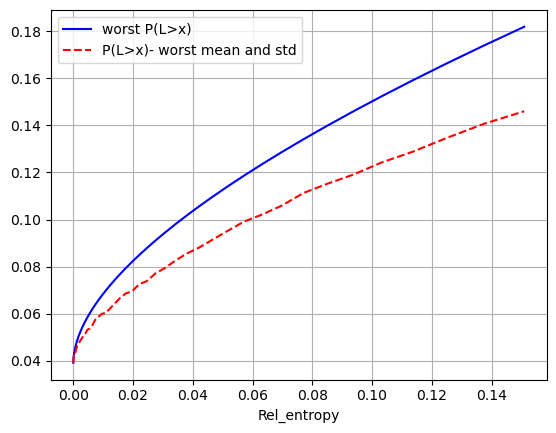

In [148]:
fig = plt.figure()
#fig.patch.set_facecolor('lightskyblue')
ax = plt.gca()
df_wc.plot(ax=ax, x='Rel_entropy',y='Prob_loss', linestyle='solid', linewidth=1.5, color='blue')
df_wc.plot(ax=ax, x='Rel_entropy', y='Param_wcProb_loss', linestyle='--', linewidth=1.5, color='red')
ax.legend(["worst P(L>x)", "P(L>x)- worst mean and std"])
ax.grid()
plt.show()

### Analysis of distributions of the stochastic variables

In [38]:
#analysis of theta in different cases; change value of theta here
theta = 2

all_stochs = np.concatenate((eps, Z[:, np.newaxis]), axis=1)
weights = np.exp(theta * L_greater_tail_th)
mean_s, cov_s = weighted_mean_cov(all_stochs, weights)

stddev = np.sqrt(np.diag(cov_s))
corr = cov_s / np.outer(stddev, stddev)

In [39]:
# Mask the diagonal elements
non_diagonal_mask = ~np.eye(corr.shape[0], dtype=bool)

# Extract the non-diagonal elements
non_diagonal_elements = corr[non_diagonal_mask]

max_rho = np.max(non_diagonal_elements)
min_rho = np.min(non_diagonal_elements)
avg_rho = np.mean(np.abs(non_diagonal_elements))
avg_mu = np.mean(mean_s[:-1])
avg_sigeps = np.mean(stddev[:-1])

skewness = np.zeros(n)
for i in range(n):
    m3 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 3) / np.sum(weights)
    skewness[i] = m3 /(stddev[i] ** 3)

avg_skew = np.mean(skewness)

kurtosis = np.zeros(n)
for i in range(n):
    m4 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 4) / (np.sum(weights)-1)
    m2 = np.sum(weights * (eps[:, i] - mean_s[i]) ** 2) / np.sum(weights)
    kurtosis[i] = (m4/ m2**2)  - 3

avg_ex_kurt = np.mean(kurtosis)

mean_Z = mean_s[-1]
stddev_Z = stddev[-1]

In [40]:
#from scipy.stats import kurtosis
# Calculate sample excess kurtosis
#excess_kurtosis = kurtosis(data, fisher=True)
#print("Sample excess kurtosis:", excess_kurtosis)

In [41]:
# Greek symbols
rho = '\u03C1'
mu = '\u03BC'
sigma = '\u03C3'
epsilon = '\u03B5'
# Print the values using formatted strings
print((f"max({rho}_ij, {rho}_iZ) :\t {max_rho:.3e} ").expandtabs(28))
print((f"min({rho}_ij, {rho}_iZ) :\t {min_rho:.3e} ").expandtabs(28))
print((f"average(|{rho}_ij|, |{rho}_iZ|) :\t {avg_rho:.3e} ").expandtabs(28))
print((f"average({mu}_j):\t {avg_mu:.3e} ").expandtabs(28))
print((f"average({sigma}_j):\t {avg_sigeps:.2f}").expandtabs(28))
print((f"average(skew_j):\t {avg_skew:.3e} ").expandtabs(28))
print((f"average(excess kurtosis_j):\t {avg_ex_kurt:.3e} ").expandtabs(28))
print((f"mean of Z:\t {mean_Z:.3f} ").expandtabs(28))
print((f"standard deviation of Z:\t {stddev_Z:.2f} ").expandtabs(28))

max(ρ_ij, ρ_iZ) :            1.192e-02 
min(ρ_ij, ρ_iZ) :            -5.377e-03 
average(|ρ_ij|, |ρ_iZ|) :    1.246e-03 
average(μ_j):                6.607e-03 
average(σ_j):                1.01
average(skew_j):             1.308e-02 
average(excess kurtosis_j):  -1.186e-03 
mean of Z:                   0.405 
standard deviation of Z:     1.23 


In [42]:
# Only Ex kurtosis is giving wrong values , mayb the formula is wrong.

### Contour plots of Joint Distribution

In [52]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0), (0.25, 0.0, 0.0), (0.5, 0.0, 0.0), (0.75, 1.0, 1.0), (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.0, 0.0), (0.25, 0.0, 0.0), (0.5, 1.0, 1.0), (0.75, 1.0, 1.0), (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 1.0, 1.0), (0.25, 1.0, 1.0), (0.5, 0.0, 0.0), (0.75, 0.0, 0.0), (1.0, 0.0, 0.0)]
}
custom_cmap = LinearSegmentedColormap('CustomMap', cdict)

Text(0.5, 1.0, 'Joint density of $\\epsilon_{99}$ and $\\epsilon_{100}$ with $\\theta = 2$')

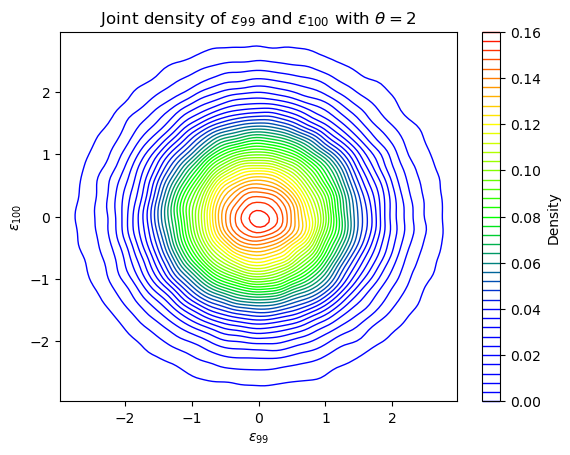

In [53]:
#change theta above to see change the plots here as well
range_ = [-3, 3]
H, xedges, yedges = np.histogram2d(eps[:, 98], eps[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenters, ycenters)

plt.contour(X, Y, H_smooth.T, levels=40, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$\epsilon_{99}$')
plt.ylabel('$\epsilon_{100}$')
plt.title(f'Joint density of $\\epsilon_{{99}}$ and $\\epsilon_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Joint density of $Z$ and $\\epsilon_{100}$ with $\\theta = 2$')

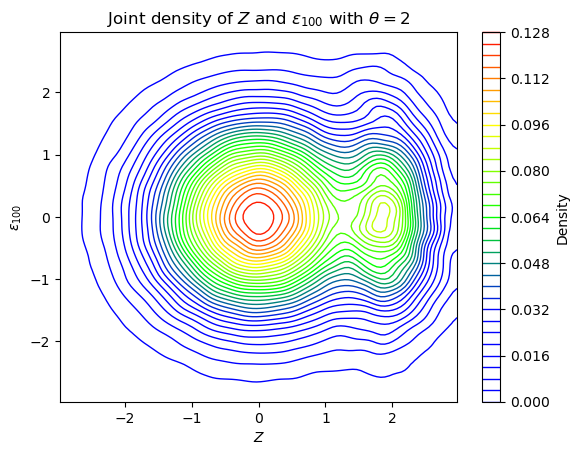

In [55]:
range_ = [-3, 3]
H, _, _ = np.histogram2d(Z, eps[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=40, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$Z$')
plt.ylabel('$\epsilon_{100}$')
plt.title(f'Joint density of $Z$ and $\\epsilon_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Joint density of $X_{99}$ and $X_{100}$ with $\\theta = 2$')

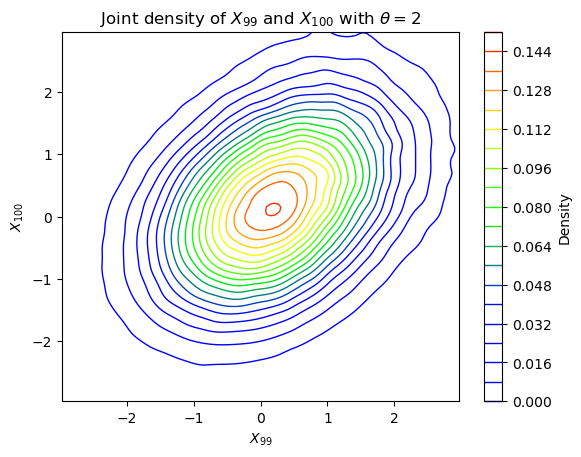

In [56]:
range_ = [-3, 3]
H, _, _ = np.histogram2d(X_i[:, 98], X_i[:, 99], bins=100, density=True, weights=weights, range=[range_, range_])
# Apply Gaussian filter to smooth the histogram data
H_smooth = gaussian_filter(H, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=20, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$X_{{99}}$')
plt.ylabel('$X_{{100}}$')
plt.title(f'Joint density of $X_{{99}}$ and $X_{{100}}$ with $\\theta = {theta}$')

Text(0.5, 1.0, 'Ratio of worst-case density to nominal density')

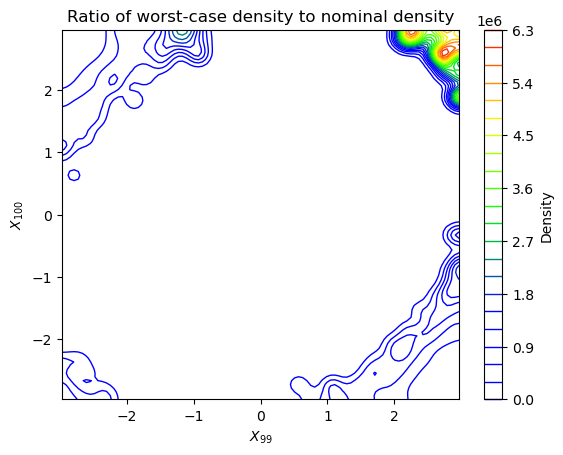

In [57]:
H_nominal, _, _ = np.histogram2d(X_i[:, 98], X_i[:, 99], bins=100, density=True, range=[range_, range_])
ratio = H_smooth / (H_nominal + 1e-10) # Avoid division by zero

H_smooth = gaussian_filter(ratio, sigma=2)  # Adjust sigma for more or less smoothing

plt.contour(X, Y, H_smooth.T, levels=20, linewidths=1, cmap=custom_cmap)
plt.colorbar(label='Density')

plt.xlabel('$X_{{99}}$')
plt.ylabel('$X_{{100}}$')
plt.title(f'Ratio of worst-case density to nominal density')

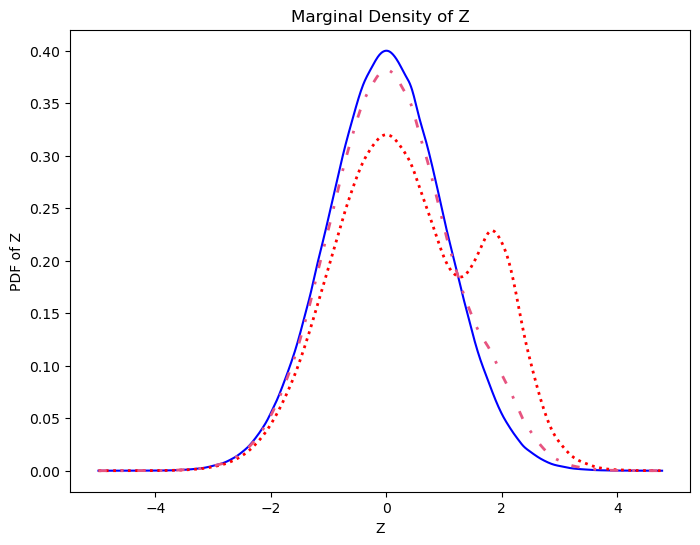

In [69]:
#Marginal density of Z and L under worst scenario with θ = 0.8 and θ = 2 vs. nominal model.
x = np.linspace(min(Z), max(Z), 1000)
plt.figure(figsize=(8, 6))

kde = gaussian_kde(Z)
density = kde.evaluate(x)
plt.plot(x, density, color='blue', linestyle='solid', linewidth=1.5, label='Density')

theta1 = 2
weights1 = np.exp(theta1 * L_greater_tail_th)
kde = gaussian_kde(Z, weights=weights1)
density = kde.evaluate(x)
plt.plot(x, density, color='red', linestyle='dotted', linewidth=2, label='Density')


theta2 = 0.8
weights2 = np.exp(theta2 * L_greater_tail_th)
kde = gaussian_kde(Z, weights=weights2)
density = kde.evaluate(x)
plt.plot(x, density, color='#E75480', linestyle = (0, (3, 5, 1, 5)), linewidth=2, label='Density')

plt.xlabel('Z')
plt.ylabel('PDF of Z')
plt.title('Marginal Density of Z')
plt.show()

In [94]:
def Loss(xi):
    defaults = xi > th
    loss = np.sum(defaults * ci)
    return loss

losses = np.apply_along_axis(Loss, 1, X_i)

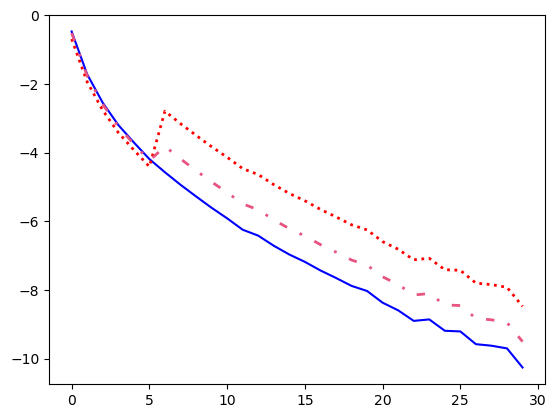

In [103]:
plot_upto = 30
plot_upto_ = plot_upto +1
dens,x = np.histogram(losses, bins= max(losses), density=True)
plt.plot(x[:1-plot_upto], np.log(dens[:plot_upto]), color='blue', linestyle='solid', linewidth=1.5)

dens,x = np.histogram(losses, bins= max(losses), density=True, weights = weights1)
plt.plot(x[:1-plot_upto], np.log(dens[:plot_upto]), color='red', linestyle='dotted', linewidth=2)

dens,x = np.histogram(losses, bins= max(losses), density=True, weights = weights2)
plt.plot(x[:1-plot_upto], np.log(dens[:plot_upto]), color='#E75480', linestyle = (0, (3, 5, 1, 5)), linewidth=2)